In [1]:
!pip install pytorch-lightning==1.5.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.
cvxpy 1.3.2 requires setu

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [3]:
random_seed = 42
torch.manual_seed(random_seed)
BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [4]:
class FMNISTDataModule(pl.LightningDataModule):
  def __init__ (self, data_dir='./data', batch_size = BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Initializes the FMNISTDataModule.

    Args:
        data_dir (str): Directory to store the dataset.
        batch_size (int): Size of the mini-batches during training.
        num_workers (int): Number of workers for DataLoader.
    """
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    # Define the data transformation pipeline
    self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

  def prepare_data(self):
    """
    Downloads and prepares the FashionMNIST dataset.
    """
    FashionMNIST(self.data_dir, train=True, download=True)
    FashionMNIST(self.data_dir, train=False, download=True)

  def setup(self, stage=None):
    """
    Splits the dataset into training, validation, and test sets.

    Args:
        stage (str, optional): 'fit' for training/validation, 'test' for testing.
    """
    if stage=="fit" or stage is None:
      fmnist_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
      self.fmnist_train, self.fmnist_val = random_split(fmnist_full, [55000, 5000])

    if stage=="test" or stage is None:
      self.fmnist_test = FashionMNIST(self.data_dir, train=False, transform=self.transform)

  def train_dataloader(self):
    """
    Returns DataLoader for the training set.
    """
    return DataLoader(self.fmnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

  def val_dataloader(self):
    """
    Returns DataLoader for the validation set.
    """
    return DataLoader(self.fmnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
    """
    Returns DataLoader for the test set.
    """
    return DataLoader(self.fmnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [5]:
# Define the Discriminator neural network class
class Discriminator(nn.Module):
  def __init__(self):
    """
    Initializes the Discriminator neural network.

    The architecture consists of convolutional layers, max-pooling, dropout, and fully connected layers.

    Input: 1 channel (grayscale image)
    Output: 1 (sigmoid activation for binary classification)
    """
    super().__init__()

    # First convolutional layer with 5x5 kernel, input channels=1, output channels=10
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

    # Second convolutional layer with 5x5 kernel, input channels=10, output channels=20
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

    # Dropout layer to prevent overfitting
    self.conv2d_drop = nn.Dropout2d()

    # Fully connected layers
    self.fc1 = nn.Linear(320, 50)     # 320 input features, 50 output features
    self.fc2 = nn.Linear(50, 1)       # 50 input features, 1 output feature

  def forward(self, x):
    """
    Defines the forward pass of the Discriminator.

    Args:
        x (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Output tensor with sigmoid activation for binary classification.
    """

    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2d_drop(self.conv2(x)), 2))

    # Reshape the tensor for the fully connected layers
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)

    # Final fully connected layer with sigmoid activation for binary classification
    x = self.fc2(x)
    return torch.sigmoid(x)

In [6]:
# Define the Generator neural network class
class Generator(nn.Module):
  def __init__(self, latent_dim):
    """
    Initializes the Generator neural network.

    The architecture consists of linear and transpose convolutional layers to generate images.

    Args:
        latent_dim (int): Dimensionality of the latent space.
    """
    super().__init__()

    # Linear layer to transform the latent space to the initial convolutional shape
    self.lin1 = nn.Linear(latent_dim, 7*7*64)

    # Transpose convolutional layers to upsample the data
    self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
    self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)

    # Final convolutional layer to generate the output image
    self.conv = nn.Conv2d(16, 1, kernel_size=7)

  def forward(self, x):
    """
    Defines the forward pass of the Generator.

    Args:
        x (torch.Tensor): Input tensor from the latent space.

    Returns:
        torch.Tensor: Output tensor representing the generated image.
    """
    # Linear layer to transform the input from latent space to initial convolutional shape
    x = self.lin1(x)
    x = F.relu(x)

    # Reshape the tensor for the transpose convolutional layers
    x = x.view(-1, 64, 7, 7)

    x = self.ct1(x)
    x = F.relu(x)

    x = self.ct2(x)
    x = F.relu(x)

    # Final convolutional layer to generate the output image
    return self.conv(x)

In [7]:
# Define the GAN LightningModule class
class GAN(pl.LightningModule):

  def __init__(self, latent_dim=100, lr=0.0002):
    """
    Initializes the GAN LightningModule.

    Args:
        latent_dim (int): Dimensionality of the latent space.
        lr (float): Learning rate for optimization.
    """
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    # Pre-generate random noise for validation
    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    """
    Defines the forward pass of the GAN.

    Args:
        z (torch.Tensor): Input tensor from the latent space.

    Returns:
        torch.Tensor: Output tensor representing the generated image.
    """
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    """
    Computes the adversarial loss using binary cross-entropy.

    Args:
        y_hat (torch.Tensor): Predictions.
        y (torch.Tensor): Ground truth labels.

    Returns:
        torch.Tensor: Adversarial loss.
    """
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx, optimizer_idx):
    """
    Defines the training step for both the Generator and the Discriminator.

    Args:
        batch: Batch of real images.
        batch_idx: Index of the current batch.
        optimizer_idx: Index of the optimizer being used (0 for Generator, 1 for Discriminator).

    Returns:
        dict: Dictionary containing the loss and logging information.
    """

    # Getting real images from the batch
    real_imgs, _ = batch

    # Creating random noise
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # For Generator
    if optimizer_idx == 0:

      # The forward step - which creates images using generator from random noise
      fake_imgs = self(z)

      # The output from the discriminator
      # 1 means the discriminator predicted this as a real image, meaning the generator did a great job
      # 0 means the discriminator predicted this as a fake image. The generator needs to improve
      y_hat = self.discriminator(fake_imgs)
      y = torch.ones(real_imgs.size(0), 1)

      y = y.type_as(real_imgs)

      g_loss = self.adversarial_loss(y_hat, y)

      log_dict = {"g_loss": g_loss}

      return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}

    # For Discriminator
    if optimizer_idx == 1:
      y_hat_real = self.discriminator(real_imgs)

      y_real = torch.ones(real_imgs.size(0), 1)
      y_real = y_real.type_as(real_imgs)

      real_loss = self.adversarial_loss(y_hat_real, y_real)

      y_hat_fake = self.discriminator(self(z).detach())
      y_fake = torch.zeros(real_imgs.size(0), 1)
      y_fake = y_fake.type_as(real_imgs)

      fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

      d_loss = (real_loss + fake_loss) / 2
      log_dict = {"d_loss": d_loss}

      return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}


  def configure_optimizers(self):
    """
    Configures the optimizers for the Generator and Discriminator.

    Returns:
        list: List of optimizers.
    """
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    return [opt_g, opt_d], []

  def plot_imgs(self):
    """
    Plots generated images using the current Generator state.
    """
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    print('epoch ', self.current_epoch)
    fig = plt.figure()

    for i in range(sample_imgs.size(0)):
      plt.subplot(2, 3, i + 1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap = 'gray_r', interpolation = 'none')
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_epoch_end(self):
    """
    Hook function called at the end of each epoch.
    """
    self.plot_imgs()


In [8]:
dm = FMNISTDataModule()
# model = GAN()

In [ ]:
# model.plot_imgs()

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


100%|██████████| 26421880/26421880 [00:02<00:00, 12556828.73it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199776.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3732639.03it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21127472.59it/s]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


epoch  0


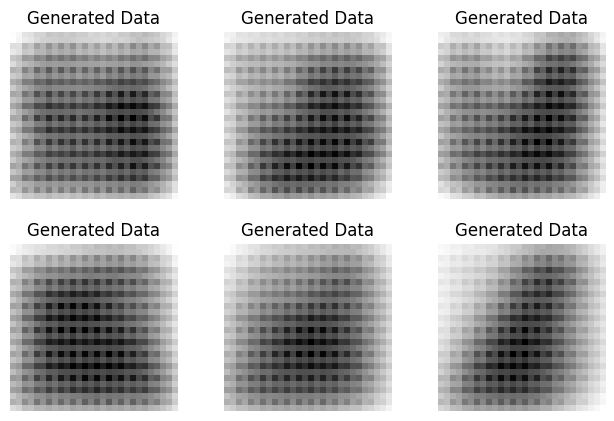

In [ ]:
# trainer = pl.Trainer(max_epochs= 1, gpus= AVAIL_GPUS)
# trainer.fit(model, dm)

In [ ]:
# trainer.save_checkpoint("/content/drive/MyDrive/Saved_Models/GAN/GAN2.ckpt")

100%|██████████| 26421880/26421880 [00:02<00:00, 11907919.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199840.00it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3753326.34it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21943370.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Current iteration is 0


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estim

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


epoch  0


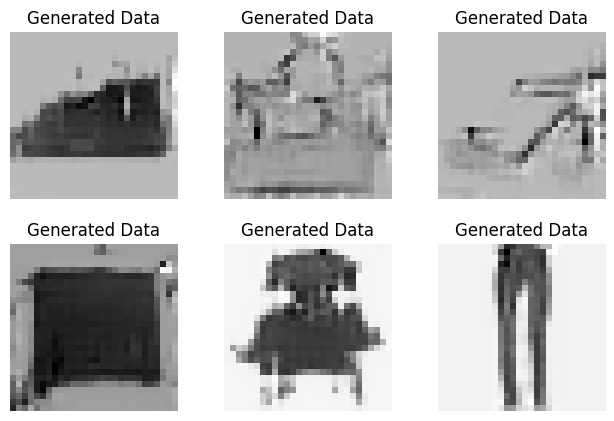

epoch  1


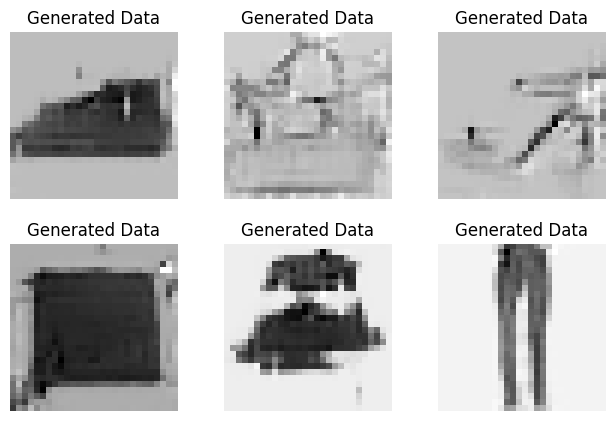

epoch  2


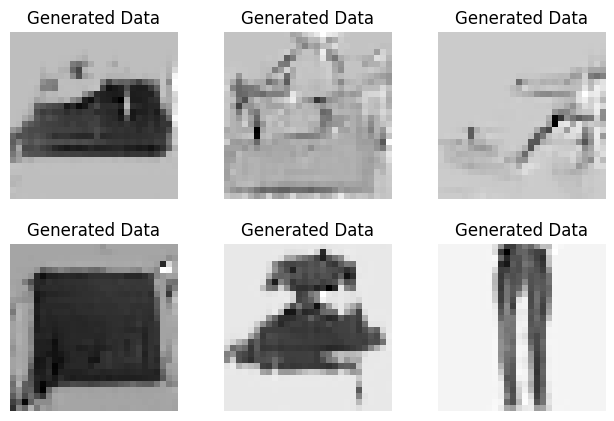

epoch  3


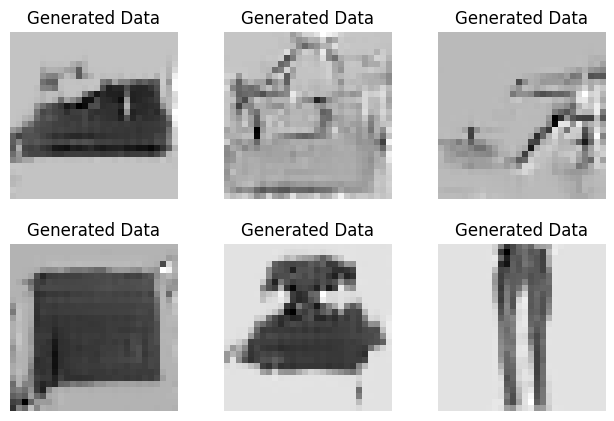

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params si

Current iteration is 1


Training: 0it [00:00, ?it/s]

epoch  0


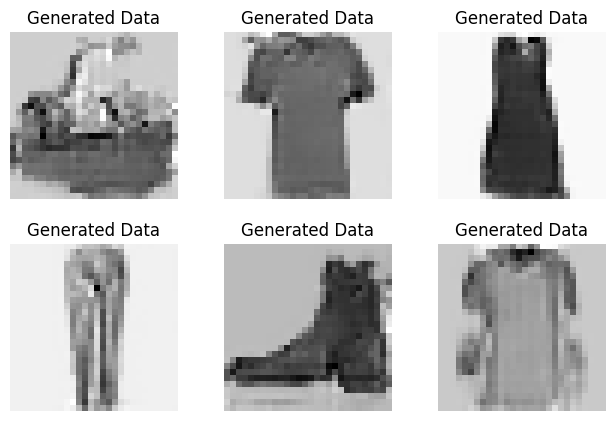

epoch  1


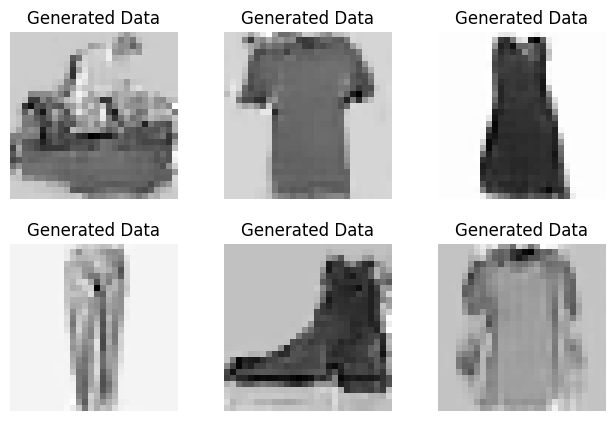

epoch  2


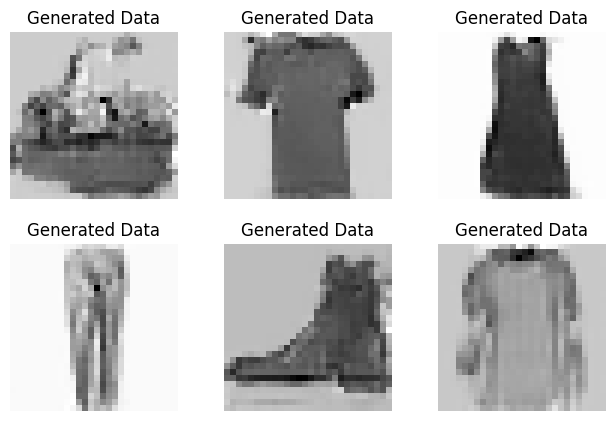

epoch  3


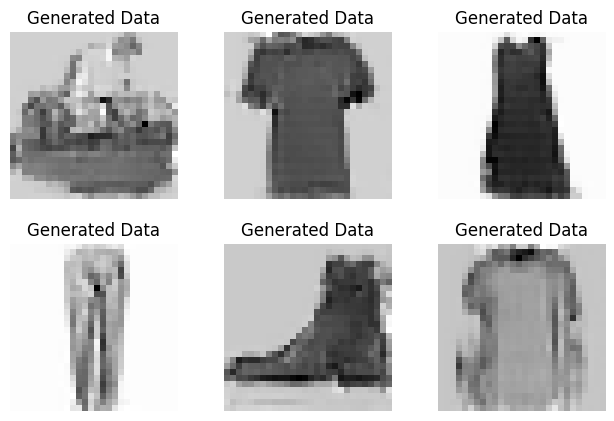

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model par

Current iteration is 2


Training: 0it [00:00, ?it/s]

epoch  0


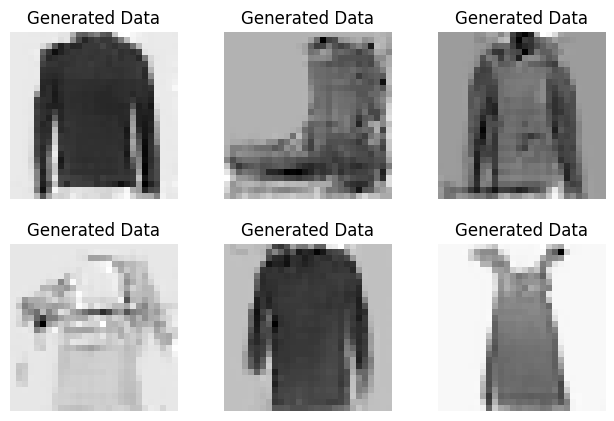

epoch  1


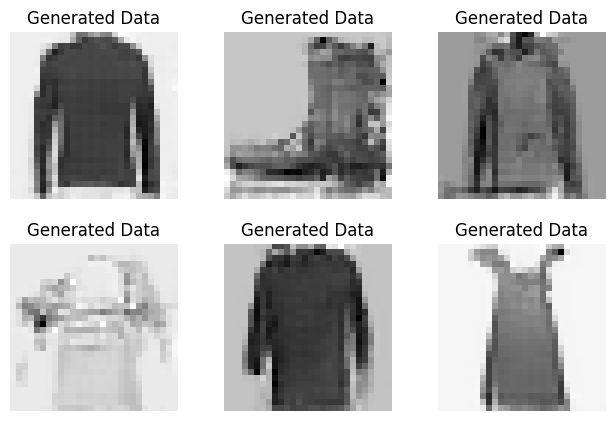

epoch  2


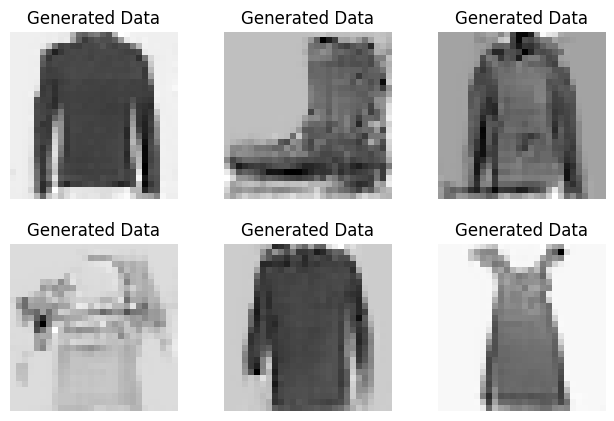

epoch  3


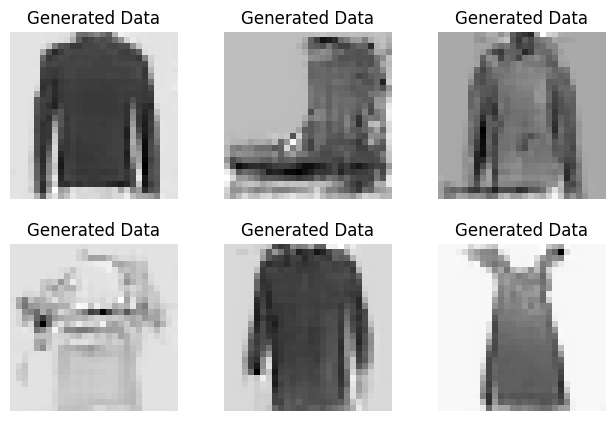

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 3


Training: 0it [00:00, ?it/s]

epoch  0


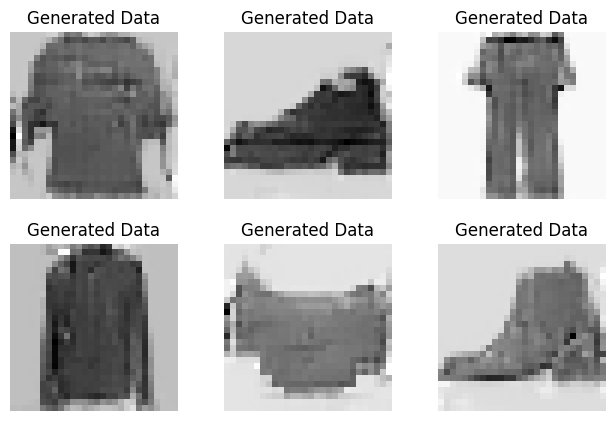

epoch  1


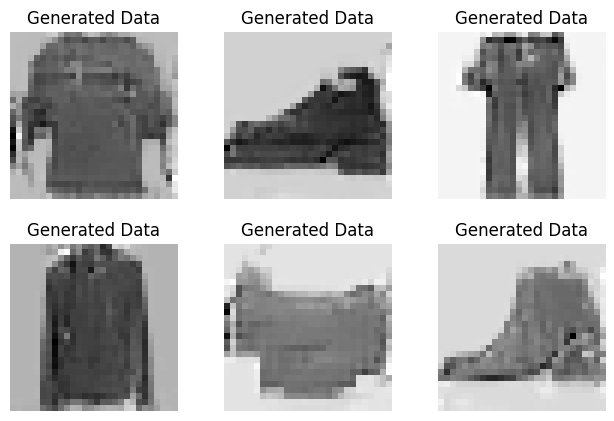

epoch  2


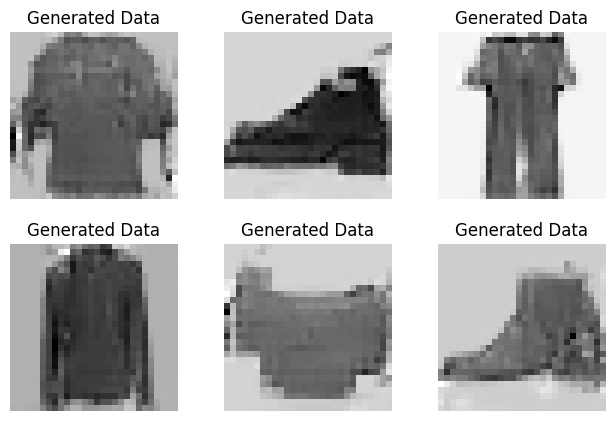

epoch  3


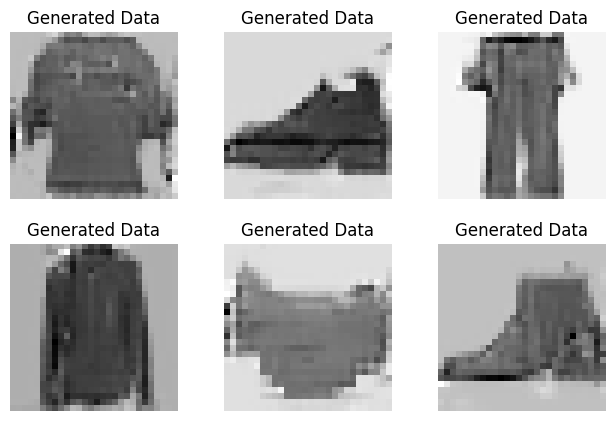

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 4


Training: 0it [00:00, ?it/s]

epoch  0


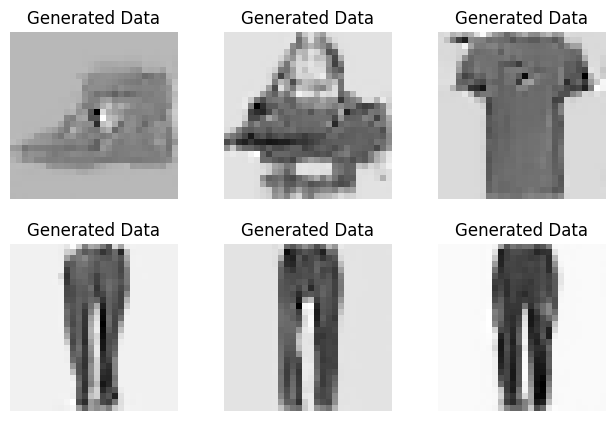

epoch  1


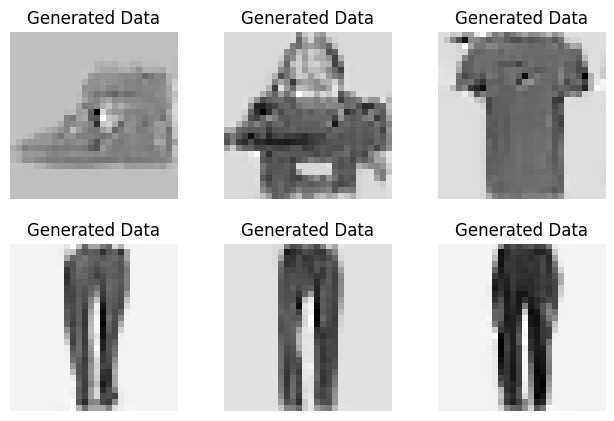

epoch  2


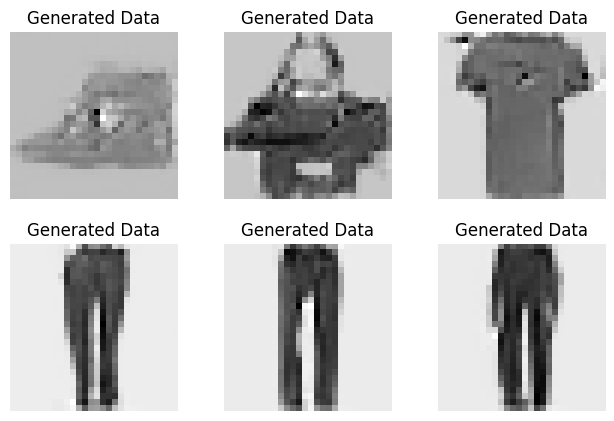

epoch  3


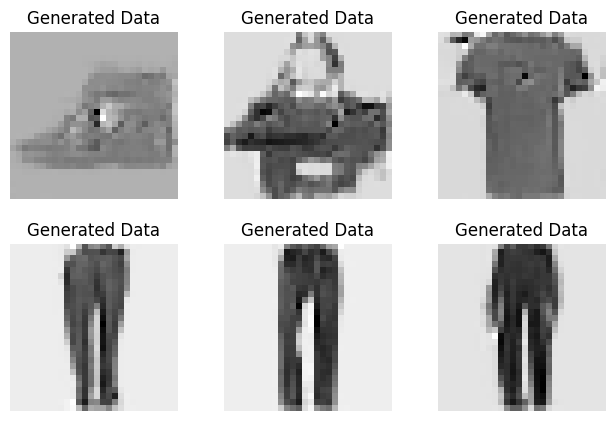

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 5


Training: 0it [00:00, ?it/s]

epoch  0


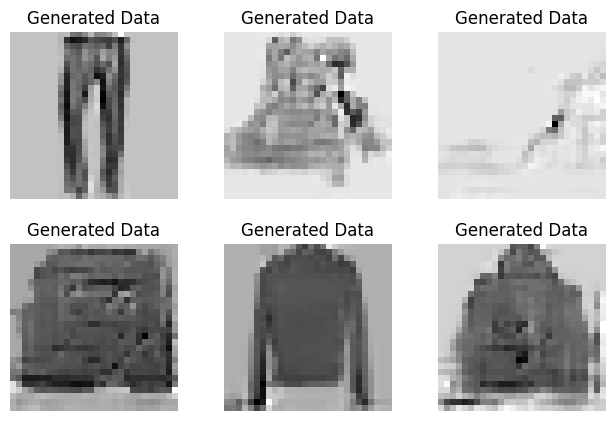

epoch  1


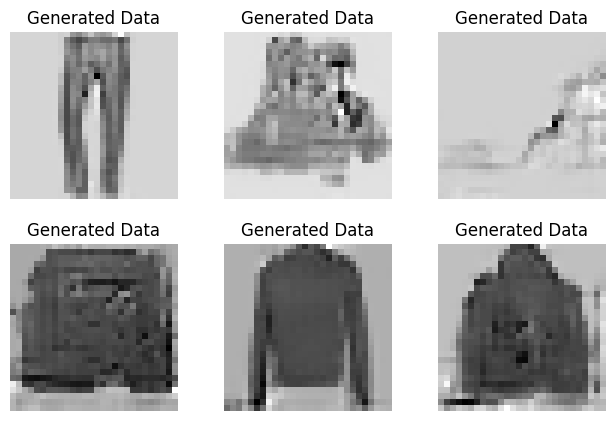

epoch  2


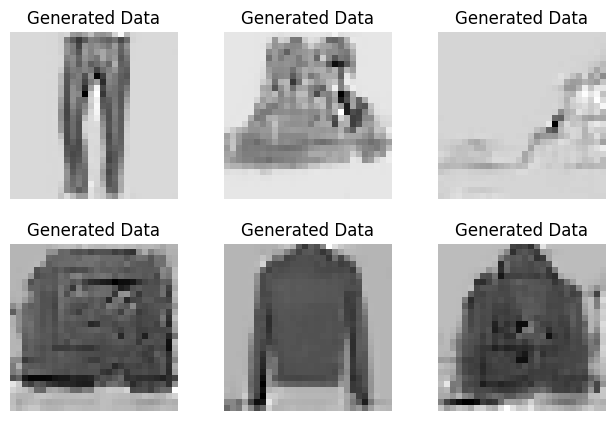

epoch  3


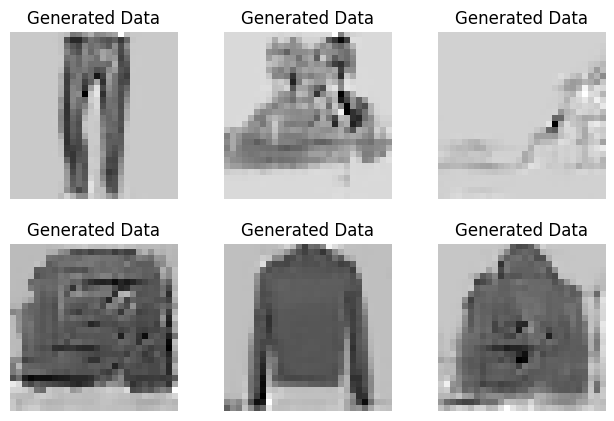

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 6


Training: 0it [00:00, ?it/s]

epoch  0


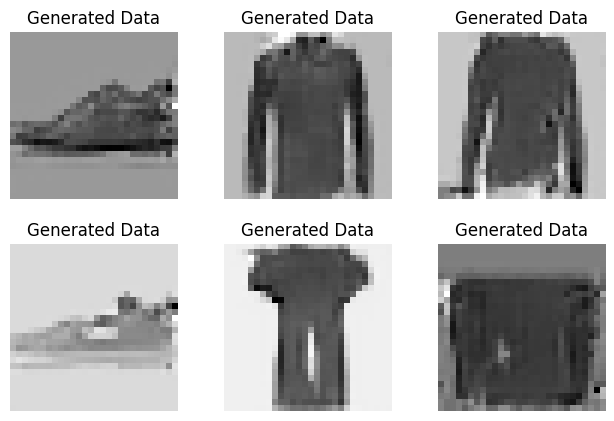

epoch  1


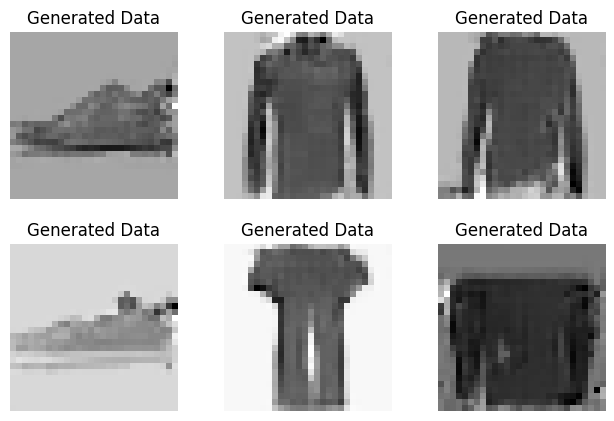

epoch  2


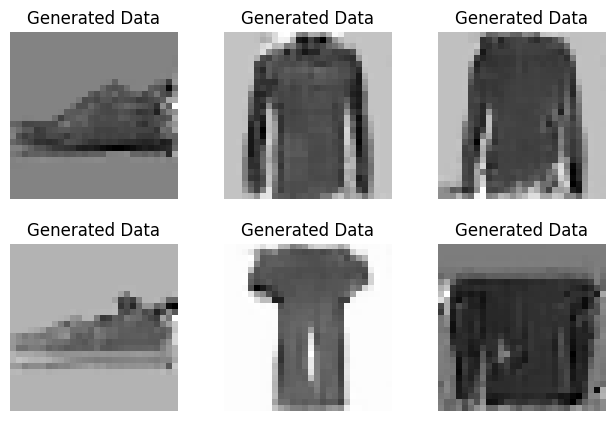

epoch  3


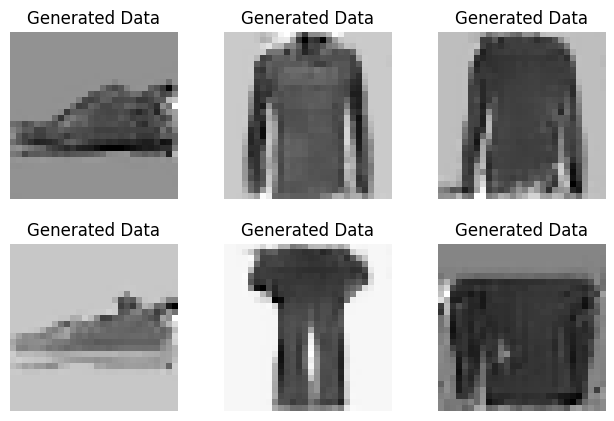

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 7


Training: 0it [00:00, ?it/s]

epoch  0


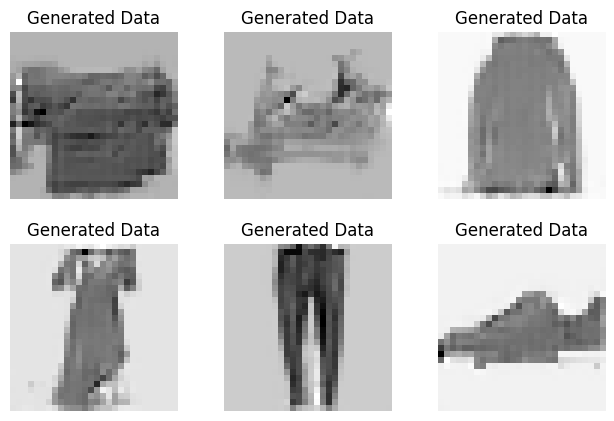

epoch  1


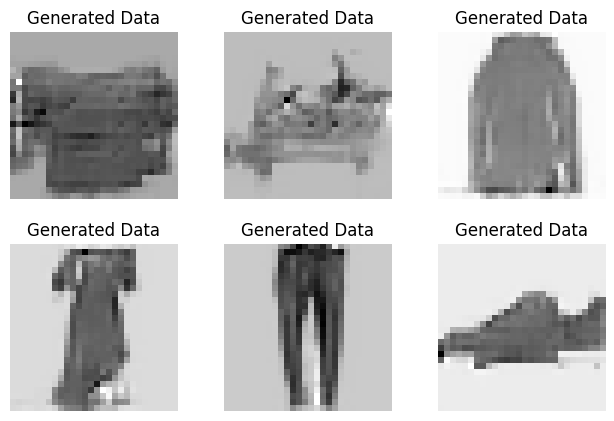

epoch  2


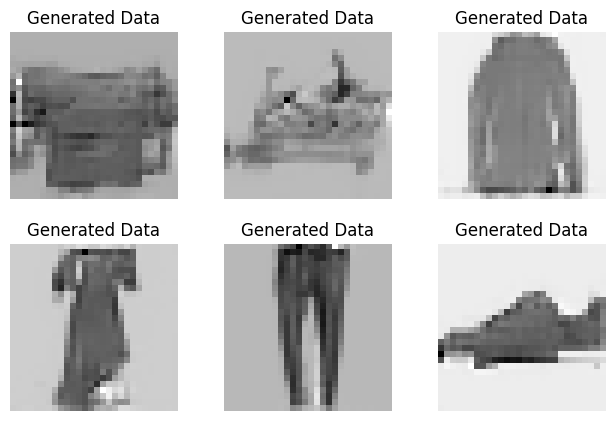

epoch  3


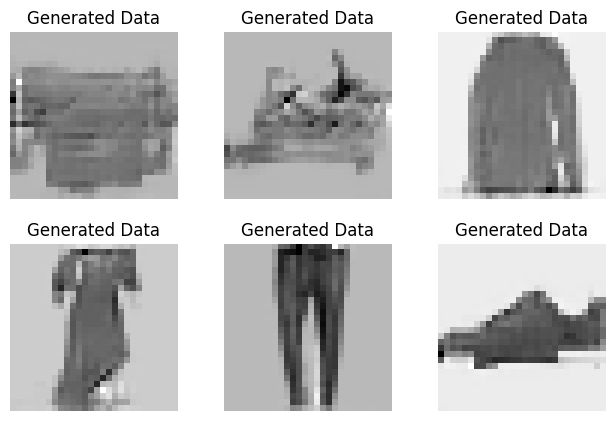

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 8


Training: 0it [00:00, ?it/s]

epoch  0


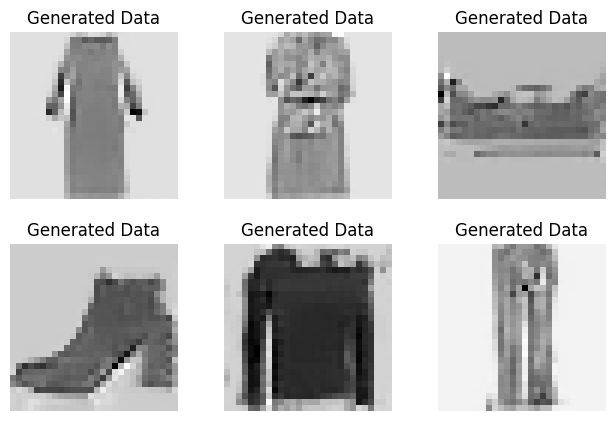

epoch  1


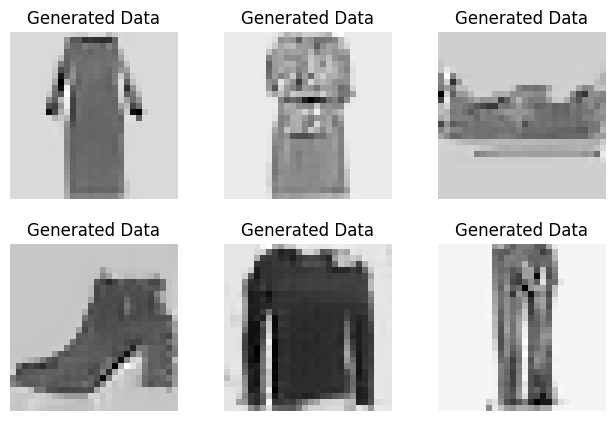

epoch  2


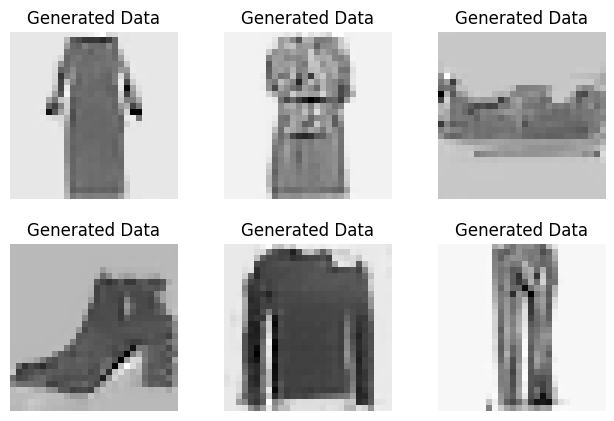

epoch  3


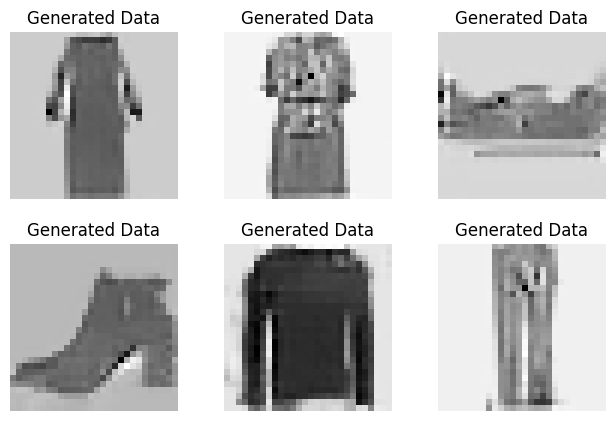

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Current iteration is 9


Training: 0it [00:00, ?it/s]

epoch  0


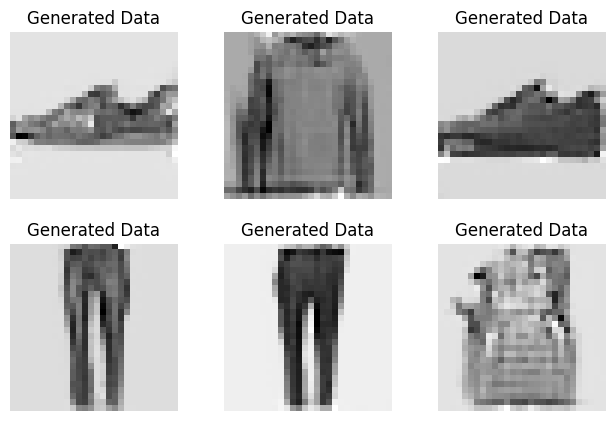

epoch  1


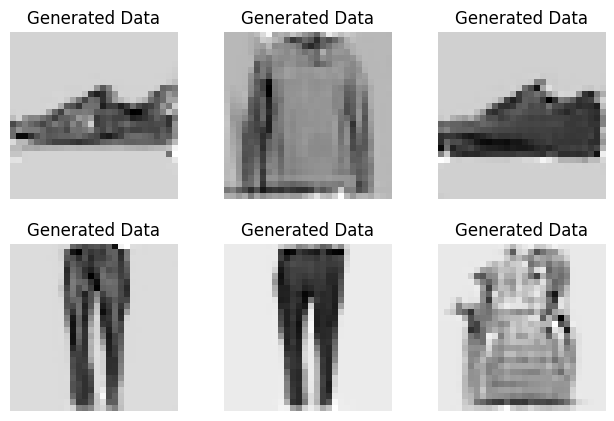

epoch  2


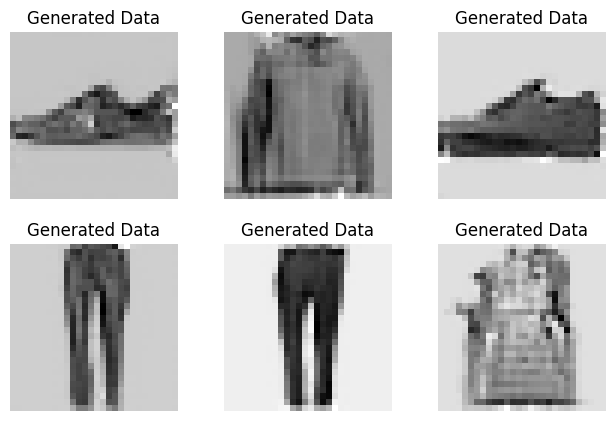

epoch  3


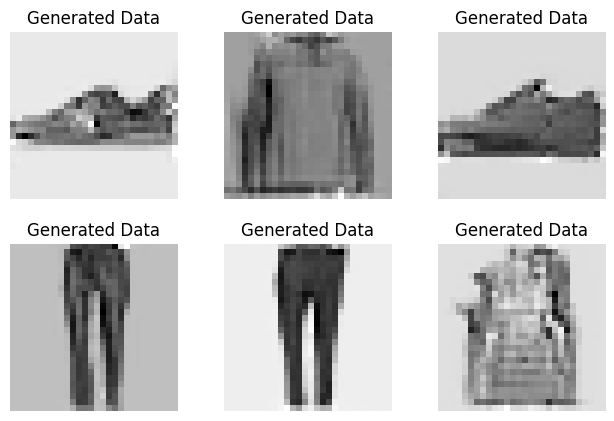

In [9]:
FashionMNIST('./data', train=False, download=True)
for i in range(10):
  print(f"Current iteration is {i}")
  model2 = GAN.load_from_checkpoint(checkpoint_path="/content/drive/MyDrive/Saved_Models/GAN/GAN2.ckpt")
  trainer = pl.Trainer(max_epochs= 4, gpus= AVAIL_GPUS)
  trainer.fit(model2, dm)
  trainer.save_checkpoint("/content/drive/MyDrive/Saved_Models/GAN/GAN2.ckpt")